In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


In [144]:
# Load the JSON file
file_path = './data.json'
data = pd.read_json(file_path)

# Flatten the nested structure
df = pd.json_normalize(data['metrics'])

# Display the DataFrame
print(df)

          date  steps  heart_rate  sleep_hours  hrv
0   2024-11-20   9200          73          7.0   48
1   2024-11-19   8700          74          6.8   46
2   2024-11-18   8000          76          6.2   44
3   2024-11-17   8900          72          7.3   49
4   2024-11-16   9500          71          7.5   51
5   2024-11-15   8600          75          6.4   45
6   2024-11-14   9100          72          7.1   48
7   2024-11-13   8700          73          6.7   47
8   2024-11-12   8800          74          6.9   46
9   2024-11-11   9000          71          7.4   50
10  2024-11-10   9400          72          7.2   49
11  2024-11-09   8900          73          6.8   48
12  2024-11-08   8700          74          6.5   46
13  2024-11-07   8600          76          6.3   45
14  2024-11-06   9200          71          7.0   49
15  2024-11-05   9500          72          7.3   51
16  2024-11-04   8800          74          6.9   46
17  2024-11-03   8500          75          6.6   45
18  2024-11-

In [145]:
df.head()

,date,steps,heart_rate,sleep_hours,hrv
0,2024-11-20,9200,73,7.0,48
1,2024-11-19,8700,74,6.8,46
2,2024-11-18,8000,76,6.2,44
3,2024-11-17,8900,72,7.3,49
4,2024-11-16,9500,71,7.5,51


<Axes: xlabel='sleep_hours', ylabel='Count'>

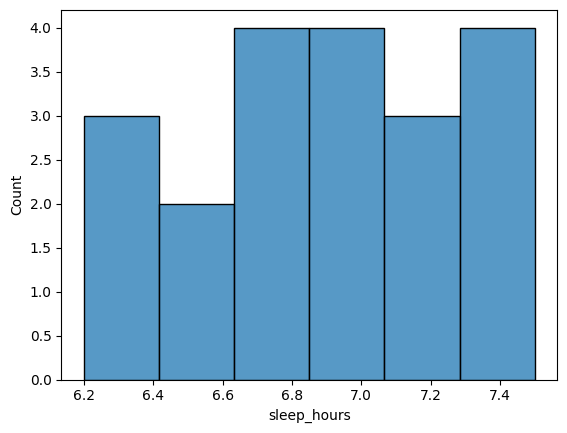

In [146]:
sns.histplot(x = 'sleep_hours', data = df)


In [147]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date', ylabel='sleep_hours'>

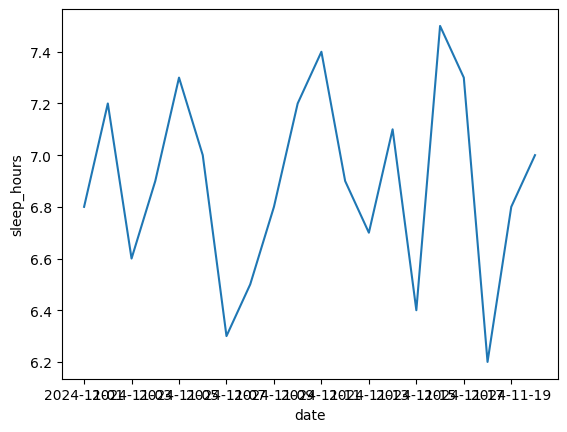

In [148]:
sns.lineplot(x = 'date', y = 'sleep_hours', data = df)

In [149]:
train_adj = df.copy()
train_adj['sleep_hours'].loc[(train_adj["date"] >= "2017-09-27") & (train_adj["date"] <= "2018-06-12")] = train_adj['sleep_hours']/1.94

C:\Users\HP\AppData\Local\Temp\ipykernel_36608\1416996182.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_adj['sleep_hours'].loc[(train_adj["date"] >= "2017-09-27") & (train_adj["date"] <= "2018-06-12")] = train_adj['sleep_hours']/

In [150]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df['sleep_hours'])

(0.07095344582491672, True)

In [151]:
a=auto_arima(df['sleep_hours'], seasonal = True, m = 12, max_p = 5, max_d = 5, max_q = 7,
          max_P = 4, max_D = 4, max_Q = 4)
a

d:\sundial combined\newenv\lib\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (8) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [152]:
arima_model = SARIMAX(df['sleep_hours'], order = (1, 1, 1))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            sleep_hours   No. Observations:                   20
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  -9.523
Date:                Thu, 28 Nov 2024   AIC                             25.046
Time:                        00:43:44   BIC                             27.880
Sample:                             0   HQIC                            25.526
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0127      0.247     -0.052      0.959      -0.498       0.472
ma.L1         -0.9985     31.314     -0.032      0.975     -62.372      60.375
sigma2         0.1364      4.246      0.032      0.974      -8.185       8.458
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.89   Prob(JB):                         0.62
Heteroskedasticity (H):               0.29   Skew:                            -0.02
Prob(H) (two-sided):                  0.15   Kurtosis:                         1.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
# Ensure the 'date' column is a datetime object
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

In [154]:


# Get the last date
last_date = df.index[0]
last_date


Timestamp('2024-11-20 00:00:00')

In [157]:
 # Assuming your DataFrame index is a DateTimeIndex
forecast_dates = pd.date_range(start=last_date, periods=8, freq='D')[1:]  # Next 7 days
forecast = arima_result.forecast(steps=7)

# Combine dates and forecast into a DataFrame
forecast_df = pd.DataFrame({'date': forecast_dates, 'predicted_sleep_hours': forecast})
forecast_df.set_index('date', inplace=True)

# Print the forecast DataFrame
print(forecast_df)



            predicted_sleep_hours
date                             
2024-11-21               6.896204
2024-11-22               6.894978
2024-11-23               6.894993
2024-11-24               6.894993
2024-11-25               6.894993
2024-11-26               6.894993
2024-11-27               6.894993


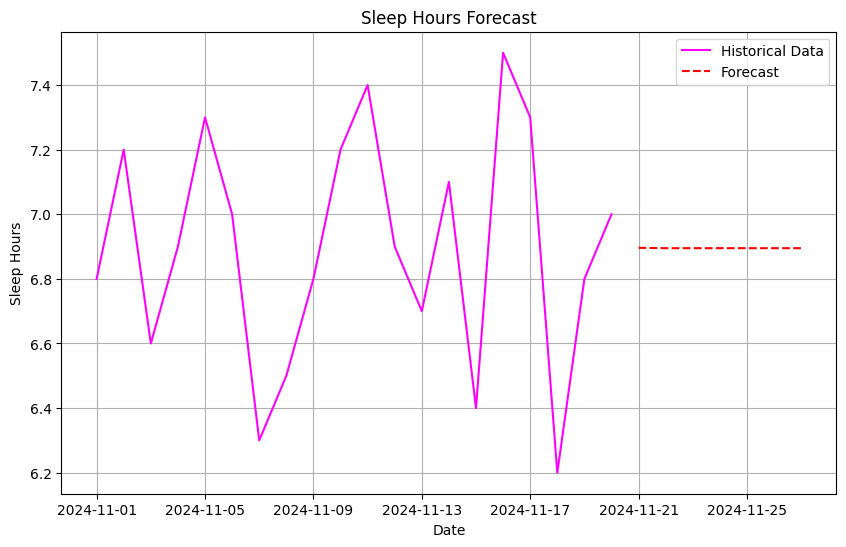

In [159]:

# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(df['sleep_hours'], label='Historical Data',color="magenta")

# Plot forecast data
plt.plot(forecast_df['predicted_sleep_hours'], label='Forecast', linestyle='--', color='red')

plt.legend()
plt.title('Sleep Hours Forecast')
plt.xlabel('Date')
plt.ylabel('Sleep Hours')
plt.grid(True)
plt.show()


In [161]:
def generate_sleep_suggestion_based_on_average(predicted_sleep_hours):
    # Calculate the average sleep hours
    avg_sleep_hours = predicted_sleep_hours.mean()
    
    # Generate a suggestion based on the average sleep hours
    if avg_sleep_hours < 6:
        suggestion = "Your average sleep time is below 6 hours. Consider establishing a consistent bedtime routine to improve your sleep quality."
    elif avg_sleep_hours < 7:
        suggestion = "Your average sleep time is slightly below 7 hours. Try to wind down earlier to ensure better rest."
    elif avg_sleep_hours >= 7 and avg_sleep_hours < 8:
        suggestion = "You're getting a decent amount of sleep. Maintaining a consistent sleep schedule can further improve your health."
    else:
        suggestion = "Great! Your average sleep time is over 8 hours. Keep up the good work for your well-being."
    
    return avg_sleep_hours, suggestion

# Get the average sleep hours and the suggestion
avg_sleep_hours, sleep_suggestion = generate_sleep_suggestion_based_on_average(forecast_df['predicted_sleep_hours'])

# Print the result
print(f"Average Sleep Hours: {avg_sleep_hours:.2f}")
print(f"Suggestion: {sleep_suggestion}")


Average Sleep Hours: 6.90
Suggestion: Your average sleep time is slightly below 7 hours. Try to wind down earlier to ensure better rest.
